# Compression-Decompression on Whole Images

In [1]:
#@title Test Contexts
TEST_CONTEXTS=[
    "IMAGES",
    # "DATASET",
    # "ATTENTION_PROFILE",
    # "MODEL_PROFILE",
    # "MODEL_INSTANTIATION"
    
]

########## Ground Truth ##########
organs = {b'ring_fill'}
# organs = {b'ring_fill', b'circle_border'}
# organs = {b'has_neighbors'}
onehot_key="organ"


# Tensorboard

In [2]:
# !pip install -U tensorboard_plugin_profile
# %reload_ext tensorboard
# !mkdir -p /tmp/tensorboard/logs
# %tensorboard --logdir /tmp/tensorboard/logs

# Startup


In [2]:
#!pip install keras

## Imports and GPU Management

In [3]:
%matplotlib inline

import datetime

# Definition Modules
from abc import ABC, abstractmethod
from typing import Union, Optional

# Operation Modules
import numpy as np
import tensorflow as tf
from tensorflow.python.types.core import TensorLike
from keras.layers.dense_attention import BaseDenseAttention

import math
from collections import OrderedDict
from collections.abc import Mapping
from itertools import chain

# Early Visualization Imports
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('dark_background')

## Quality-of-Life Functions

In [4]:
def smart_repr(key, value):
    if isinstance(value, tf.Tensor) and tf.size(value) <= 10:
      print(f"{key:20s}: {value.numpy()} @ {value.shape} / {value.dtype}")
    elif isinstance(value, OrderedDict):
      for dk, dv in value.items():
        smart_repr(f"{key}[{dk}]", dv)
    else:
      print(f"{key:20s}: [value] @ {value.shape} / {value.dtype}")

def simple_sample(ds, reply=False):
  for batch in ds.take(1):
    for key, value in batch.items():
      smart_repr(key, value)
    if reply:
      return batch

In [5]:
#@title ChannelDict
from typing import Callable, Tuple, Dict, List, Set, Iterable

def _channel_shape(tensor:TensorLike) -> Tuple:
    if isinstance(tensor, tf.RaggedTensor):
        raise NotImplementedError("ChannelDict support for RaggedTensor is deprecated.")
        # if tensor.ragged_rank != 2:
        #     raise ValueError(f"ChannelDict cannot handle tf.RaggedTensor without ragged_rank==2 (ragged width and height). Had rank {tensor.ragged_rank} and shape {tensor.shape}")
        # ragged_dim1, repeated_ragged_dim2 = tensor.nested_row_lengths()
        # # print("Channel Shape ragged_dim1 repeated_ragged_dim2:", ragged_dim1, repeated_ragged_dim2)
        # second_dim_indices = tf.scan(lambda sum, update: sum+update, ragged_dim1, initializer=tf.cast(-1, tf.int64))
        # ragged_dim2 = tf.gather(repeated_ragged_dim2, second_dim_indices)
        # ragged_dims = [ragged_dim1, ragged_dim2]

        # return tuple([
        #     tuple(ragged_dims.pop(0).numpy())
        #     if ragged_dim is None else ragged_dim
        #     for ragged_dim in tensor.shape[:-1]
        # ])
    else:
        return tuple(tensor.shape[:-1])

def _pack(to_pack:Iterable[TensorLike]) -> TensorLike:
    return tf.concat(list(to_pack), axis=-1)

class ChannelDict(OrderedDict):
    def shapes(self) -> Tuple[Dict[tuple, Set[str]], int]:
        total_channels=0

        shapes = OrderedDict()
        for k, t in self.items():
            shapes.setdefault(_channel_shape(t), set()).add(k)
            total_channels += t.shape[-1]
        return shapes, total_channels

    def keychannels(self) -> 'OrderedDict[str, int]':
        return OrderedDict([(key, value.shape[-1]) for key, value in self.items()])

    def repack(self) -> 'Tuple[TensorLike, OrderedDict[str, int]]':
        repacked = _pack(self.values())
        return repacked, self.keychannels()

    def packapply(self, fn:Callable[[TensorLike], TensorLike], keyfn:'Callable[[OrderedDict[str, int], OrderedDict[str,int]]]'=lambda x: x, *args, **kwargs) -> 'ChannelDict[str, TensorLike]':
        repacked, keychannel_dict = self.repack()
        result = fn(repacked, *args, **kwargs)
        keychannel_updated = keyfn(keychannel_dict)
        return ChannelDict.resplit(result, keychannel_updated)
    
    def subset(self, ordered_keys:List[str]=None, unordered_keys:Set[str]=None, invert=False) -> 'ChannelDict':
        if ordered_keys is None and unordered_keys is None:
            raise ValueError("ChannelDict subset was given no keys to subset.")
        
        if ordered_keys is not None and unordered_keys is not None:
            raise ValueError("ChannelDict subset was given both ordered and unordered keys to subset - must only have one.")
        
        if ordered_keys is not None:
            return ChannelDict(**{key: self[key] for key in ordered_keys if key in self})
            # return _pack([self[key] for key in ordered_keys if key in self])
        else:
            return ChannelDict(**{key: self[key] for key in self.keys() if ((key in unordered_keys) != invert)})
            # return _pack([value for key, value in self.items() if key in unordered_keys])

    def partialpack(self, ordered_keys:List[str]=None, unordered_keys:Set[str]=None, invert=False) -> TensorLike:
        if ordered_keys is None and unordered_keys is None:
            raise ValueError("ChannelDict partialpack was given no keys to pack.")
        
        if ordered_keys is not None and unordered_keys is not None:
            raise ValueError("ChannelDict partialpack was given both ordered and unordered keys to pack - must only have one.")
        
        if ordered_keys is not None:
            return _pack([self[key] for key in ordered_keys if key in self])
        else:
            return _pack([value for key, value in self.items() if ((key in unordered_keys) != invert)])

    def unbatch(self, axis=0):
        batch_tensor, keychannels = self.repack()
        return [ChannelDict.resplit(tensor, keychannels) for tensor in tf.unstack(batch_tensor, axis=axis)]

    @staticmethod
    def resplit(packed_tensor:TensorLike, keys_channels:'OrderedDict[str, int]') -> 'ChannelDict[str, TensorLike]':
        split = ChannelDict()
        channel_idx = 0
        for key, channel_w in keys_channels.items():
            split[key] = packed_tensor[..., channel_idx:channel_idx+channel_w]
            channel_idx += channel_w
        return split
    
    ## @staticmethod
    # def stack(elements:'List[ChannelDict[str, TensorLike]]') -> 'ChannelDict[str, TensorLike]':
    #     tensors = []
    #     unique_keychannels = set()
    #     unique_dims = set()
    #     for elem in elements:
    #         tensor, keychannels = elem.repack()
    #         unique_keychannels.add(str(keychannels))
    #         tensors.append(tensor)

    #         shape, _ = elem.shapes()
    #         unique_dims.add(next(iter(shape.keys())))

    #     if len(unique_keychannels) != 1:
    #         raise NotImplementedError("ChannelDict.stack got ChannelDicts with non-identical keychannels.")

    #     if len(unique_dims) == 1:
    #         stacked = tf.stack(tensors)
    #     else:
    #         stacked = tf.ragged.stack(tensors)

    #     # We snuck 'keychannels' into locals when we defined it in the first for-loop.
    #     return ChannelDict.resplit(stacked, keychannels)

# def batch(dataset:tf.data.Dataset, *args, **kwargs) -> 'tf.data.Dataset':
#     element_spec=dataset.element_spec
#     keychannels = element_spec.keychannels()
    
#     batched_packed_dataset = dataset.map(lambda cd: tf.RaggedTensor.from_tensor(cd.repack()[0])).batch(*args, **kwargs)
#     batched_resplit_dataset= batched_packed_dataset.map(lambda tensor: ChannelDict.resplit(tensor, keychannels))

#     return batched_resplit_dataset

def split_data_to_x_y(data:'ChannelDict[str, TensorLike]') -> 'Tuple[ChannelDict[str, TensorLike], TensorLike]':
    return data.subset(unordered_keys={"target"}, invert=True), data["target"]

In [6]:
def imshow_c(im):
    if isinstance(im, tf.RaggedTensor):
        im = im.to_tensor(0)
    imc = im.shape[-1]
    if imc == 1:
        plt.imshow(im[..., 0])
    elif imc <= 3:
        plt.imshow(tf.pad(im, [(0, 0), (0, 0), (0, 3-imc)]))
    elif len(im.shape) == 2:
        plt.imshow(im)
    else:
        raise NotImplementedError("imshow_c can't show more-than-3-channel images")

# Dataset Pipeline
`construct_spatial_dataset() -> tf.data.Dataset[ChannelDict<b, w, h, c>]`

## Image and Metadata Origination
`make_pretransformed_images_dataset() -> tf.data.Dataset[OrderedDict[str, [str, float, int[2], ChannelDict]]`

### Hyperparameters

In [14]:
#@title RandomSample HyperParameters
########### ALL IMAGES #################
organs_l = list(organs)
SIZE_MIN,    SIZE_MAX    = 1000, 1100
PX_SIZE_MIN, PX_SIZE_MAX = 0.001, .002

########### RINGS ######################
NUM_RINGS = 15
# NUM_RINGS = 2

RING_MIN_R1_THICKNESS = [[0.05], [0.03]]
RING_MAX_R1_THICKNESS = [[0.075], [0.045]]

RING_BLEND_RADIUS = 0.001
RING_BLEND_RADIUS_INV = 1.0/RING_BLEND_RADIUS

### Unitized Ruling Functions

In [8]:
@tf.function
def make_unitized_rulers(img_w_h, pixel_size):
  xy_virtual_size = tf.cast(img_w_h, tf.float32)*tf.expand_dims(tf.cast(pixel_size, tf.float32), axis=-1)
  h_ruler = tf.linspace(0.0, xy_virtual_size[0], img_w_h[0])
  v_ruler = tf.linspace(0.0, xy_virtual_size[1], img_w_h[1])
  return [h_ruler, v_ruler], xy_virtual_size

@tf.function
def make_unitized_meshgrid(img_w_h, pixel_size):
  [h_ruler, v_ruler], xy_virtual_size = make_unitized_rulers(img_w_h, pixel_size)

  H, V = tf.meshgrid(h_ruler, v_ruler)
  return tf.stack([H, V]), xy_virtual_size

### Pattern Constructors

In [15]:
@tf.function
def ring_inner_outer(img_w_h, pixel_size):
    [h_ruler, v_ruler], xy_virtual_size = make_unitized_rulers(img_w_h, pixel_size)

    xyv = tf.expand_dims(xy_virtual_size, axis=-1)
    min_xy = xyv*0.1
    max_xy = xyv*0.9
    rings_xy = tf.random.uniform([2, NUM_RINGS], minval=min_xy, maxval=max_xy)

    rings_r1_t = tf.random.uniform([2, NUM_RINGS], minval=RING_MIN_R1_THICKNESS, maxval=RING_MAX_R1_THICKNESS)
    rings_r1 = rings_r1_t[0]
    rings_r2 = tf.reduce_sum(rings_r1_t, axis=0)


    xr = tf.abs(h_ruler[:, None] - rings_xy[0, None, :])
    yr = tf.abs(v_ruler[:, None] - rings_xy[1, None, :])
    # print(xr.shape)

    rr = tf.math.sqrt(tf.math.square(xr)[None, :, :] + tf.math.square(yr)[:, None, :])
    # print(rr.shape)

    k1 = rings_r1 - rr + RING_BLEND_RADIUS
    k2 = rings_r2 - rr + RING_BLEND_RADIUS
    # print(k1.shape, k2.shape)

    m1 = tf.maximum(0.0, tf.minimum(1.0, k1*RING_BLEND_RADIUS_INV*0.5))
    m2 = tf.maximum(0.0, tf.minimum(1.0, k2*RING_BLEND_RADIUS_INV*0.5))
    m2 = m2-m1
    m1 = tf.reduce_max(m1, axis=-1, keepdims=True)
    m2 = tf.reduce_max(m2, axis=-1, keepdims=True)

    m2 = tf.maximum(0.0, m2-(m1*100)); print("WARNING! ring_inner_outer is TOTALLY CHEATING!")
    return m1, m2


def make_ring_fill(img_w_h, pixel_size):
  inner, outer = ring_inner_outer(img_w_h, pixel_size)
  return ChannelDict(target = inner, source=outer)

def make_circle_border(img_w_h, pixel_size):
  inner, outer = ring_inner_outer(img_w_h, pixel_size)
  return ChannelDict(target = outer, source=inner)

### Sample and Dataset sources

In [16]:
constructor_lookup = {
    b"ring_fill": make_ring_fill,
    b"circle_border": make_circle_border,
}

@tf.function
def construct_sample_around_constructor(constructor_title, constructor_fn):
    print("Constructing new sample...")
    img_w_h = tf.random.uniform((2,), minval=SIZE_MIN, maxval=SIZE_MAX, dtype=tf.int32)
    pixel_size = tf.random.uniform((), minval=PX_SIZE_MIN, maxval=PX_SIZE_MAX, dtype=tf.float32)
    operation = constructor_title

    # Construct spatial data
    spatial_data = constructor_fn(img_w_h, pixel_size)

    return OrderedDict([
                        (onehot_key, operation),
                        ("pixel_size", pixel_size),
                        ("img_w_h", img_w_h),
                        ("spatial_data", spatial_data)
    ])


@tf.function
def make_dataset_around_constructor(constructor_title, constructor_fn):
    return tf.data.Dataset.random().map(
        lambda d: construct_sample_around_constructor(constructor_title, constructor_fn), 
        name=f"sample_construction_{constructor_title.decode()}", 
        # num_parallel_calls=2
        ).prefetch(1)

@tf.function
def make_all_construction_datasets():
  return [make_dataset_around_constructor(k, constructor_lookup[k]) for k in organs_l]

@tf.function
def make_pretransformed_images_dataset():
  return tf.data.Dataset.sample_from_datasets(make_all_construction_datasets())


### Tests

TESTING RING FILL EXAMPLE DATA
WARNING! ring_inner_outer is TOTALLY CHEATING!
Observed coverage: 0.32657892
Upper bound on circle coverage: 0.6785840131753953


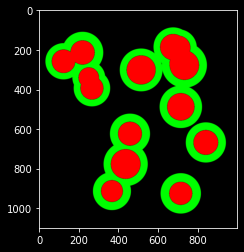

In [17]:
if "IMAGES" in TEST_CONTEXTS:
    print("TESTING RING FILL EXAMPLE DATA")
    ring_fill_sample = make_ring_fill([SIZE_MIN, SIZE_MAX], PX_SIZE_MIN)
    ring_fill_tensor, _ = ring_fill_sample.repack()
    imshow_c(ring_fill_tensor)
    print("Observed coverage:", tf.reduce_sum(tf.reduce_mean(ring_fill_tensor, axis=[0, 1])).numpy())
    upper_bound_circle_area = np.pi * (np.sum(RING_MAX_R1_THICKNESS)**2 * NUM_RINGS)
    lower_bound_image_area = (SIZE_MIN*PX_SIZE_MIN) ** 2

    upper_bound_circle_fraction = upper_bound_circle_area / lower_bound_image_area
    print(f"Upper bound on circle coverage:", upper_bound_circle_fraction)
    del ring_fill_sample
    del ring_fill_tensor

In [18]:
if "IMAGES" in TEST_CONTEXTS:
    ptim_ds_test = make_pretransformed_images_dataset()
    print(ptim_ds_test.element_spec)

Constructing new sample...
WARNING! ring_inner_outer is TOTALLY CHEATING!
OrderedDict([('organ', TensorSpec(shape=(), dtype=tf.string, name=None)), ('pixel_size', TensorSpec(shape=(), dtype=tf.float32, name=None)), ('img_w_h', TensorSpec(shape=(2,), dtype=tf.int32, name=None)), ('spatial_data', ChannelDict([('target', TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None)), ('source', TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))]))])


organ               : b'ring_fill' @ () / <dtype: 'string'>
pixel_size          : 0.006380545441061258 @ () / <dtype: 'float32'>
img_w_h             : [1025 1077] @ (2,) / <dtype: 'int32'>
spatial_data[target]: [value] @ (1077, 1025, 1) / <dtype: 'float32'>
spatial_data[source]: [value] @ (1077, 1025, 1) / <dtype: 'float32'>


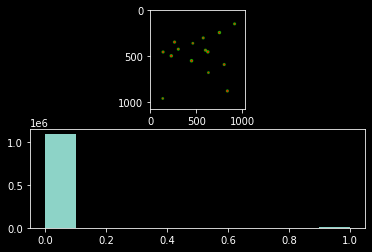

In [13]:
if "IMAGES" in TEST_CONTEXTS:
    ptim_ds_test = make_pretransformed_images_dataset()
    ptim_sample = simple_sample(ptim_ds_test, reply=True)
    ptim_sample_spatial, _ = ptim_sample["spatial_data"].repack()
    fig, ax = plt.subplots(2)
    ax[0].imshow(tf.pad(ptim_sample_spatial, [(0, 0), (0, 0), (0, 1)]), vmin=0, vmax=1)
    ax[1].hist(tf.reshape(ptim_sample_spatial[..., 0], (-1)))
    del ptim_ds_test
    del ptim_sample
    del ptim_sample_spatial

## Spatial Information Construction
`construct_spatial_dataset = lambda: make_pretransformed_images_dataset().map(build_spatial_data)`

### Dataset Hyperparameters


In [19]:
#@title Dataset Hyperparameters

TARGET_CHANNELS = 1
SRC_IM_CHANNELS = 1
CATEGORY_1HOT_D = len(organs)


########## Embedding spatial information ##########
EMBED_UM_PER_PX = True
NUM_UM_PER_PX_C = 1 if EMBED_UM_PER_PX else 0

USE_ORIGINAL_XY = False
ORIGINAL_XY_CHN = 2 if USE_ORIGINAL_XY else 0

SINE_ANNOTATION = False and USE_ORIGINAL_XY
SIN_FREQUENCIES = [0.1, 1, 10]
SINE_ANNOTATE_N = 2*len(SIN_FREQUENCIES) if SINE_ANNOTATION else 0

USE_CENTER_DIST = False and USE_ORIGINAL_XY
CENTER_DIST_CHN = 1 if USE_CENTER_DIST else 0

########## Annotation Summary ##########
# The annotated image dims will be:
# [width, height, ORIGINAL_XY_CHN + TARGET_CHANNELS + SRC_IM_CHANNELS + CATEGORY_1HOT_D + SINE_ANNOTATE_N + CENTER_DIST_CHN]
SOURCE_CHANNELS = SRC_IM_CHANNELS + CATEGORY_1HOT_D + NUM_UM_PER_PX_C + SINE_ANNOTATE_N + CENTER_DIST_CHN # Channels which will be fed as the source data to the model
PREPRO_CHANNELS = ORIGINAL_XY_CHN + TARGET_CHANNELS + SOURCE_CHANNELS                   # Total channels coming off the annotation pipeline

########## Delivery Parameters ##########
DATASET_BATCH_N = 1
PREPRO_DOWNSIZE = 1

### Construct fullsize image spatial data

In [20]:
@tf.function
def compute_original_coordinates(img_w_h, pixel_size):
  um_wh_2 = (tf.cast(img_w_h, tf.float32)*tf.expand_dims(pixel_size, axis=-1))/2.0
  h_ruler = tf.linspace(-um_wh_2[0], um_wh_2[0], img_w_h[0])
  v_ruler = tf.linspace(-um_wh_2[1], um_wh_2[1], img_w_h[1])
  XY = tf.stack(tf.meshgrid(h_ruler, v_ruler), axis=-1)

  return XY

In [21]:
@tf.function
def compute_center_distance(XY):
  XYSquaredSum = tf.reduce_sum(tf.math.square(XY), axis=-1)
  DistFromCenter = tf.math.sqrt(
    tf.reduce_sum(
        tf.math.square(XY), 
        axis=-1,
        keepdims=True
    )
  )
  return DistFromCenter

@tf.function
def compute_sine_rulers(XY, sin_frequencies=SIN_FREQUENCIES):
  return tf.concat([0.5 + 0.5*tf.math.sin(XY * math.pi * 2 * freq) for freq in sin_frequencies], axis=-1)

In [22]:
def tile_vector_to_size(vector, size):
    tiled = tf.tile(tf.reshape(vector, [1, 1, -1]), tf.concat([size[..., ::-1], [1]], axis=-1))
    if hasattr(vector, "shape") and len(vector.shape):
        print(f"Vector {vector} has shape {vector.shape}")
        return tf.ensure_shape(tiled, [None, None, vector.shape[-1]])
    else:
        return tf.ensure_shape(tiled, [None, None, 1])

In [23]:
# @tf.function # I wish this would work as a tf.function, but somehow it can't find an object's __repr__, so I'm leaving it this way.
def compute_onehots(input, multiples, categories=organs):
    onehot = tf.cast(tf.stack([tf.equal(input, s) for s in categories], axis=-1), dtype=tf.float32)
    onehot = tile_vector_to_size(onehot, multiples)
    return onehot

In [24]:
@tf.function
def resize_spatial_data(spatial_data, img_w_h, prepro_downsize=PREPRO_DOWNSIZE, **kwargs):
  output_shapes = tf.cast(
    tf.cast(img_w_h, tf.float32) * prepro_downsize,
    tf.int32
  )
  return tf.image.resize(spatial_data, output_shapes, preserve_aspect_ratio=True)

In [25]:
def build_spatial_data(d, onehot_key=onehot_key, embed_um_per_px=EMBED_UM_PER_PX, use_original_xy=USE_ORIGINAL_XY, use_center_dist=USE_CENTER_DIST, sine_annotation=SINE_ANNOTATION):
  ######### Embed Data
  spatial_d = d["spatial_data"]

  img_w_h    = d.pop("img_w_h")
  pixel_size = d.pop("pixel_size")
  onehot     = d.pop(onehot_key)

  spatial_d[onehot_key] = compute_onehots(onehot, img_w_h)
  print("Organs Shape:", spatial_d[onehot_key].shape)


  if embed_um_per_px:
      spatial_d["pixel_size"] = tile_vector_to_size(pixel_size, img_w_h)
      print("PX Size Shape:", spatial_d["pixel_size"].shape)

  if use_original_xy:
    XY = compute_original_coordinates(img_w_h, pixel_size)
    spatial_d["XY"] = XY

    if use_center_dist:
      spatial_d["center_dist"] = compute_center_distance(XY)
    if sine_annotation:
      spatial_d["sine_annotation"] = compute_sine_rulers(XY)
  
  ########## Do Resizing
  resized_spatial_d = spatial_d.packapply(lambda t: resize_spatial_data(t, img_w_h))
  return resized_spatial_d

In [26]:
construct_spatial_dataset = lambda: make_pretransformed_images_dataset().map(build_spatial_data, name="Build_Spatial_Data").batch(1)#.apply(lambda dataset: batch(dataset, 4, num_parallel_calls=tf.data.AUTOTUNE))

## Pipeline Test

In [27]:
if "DATASET" in TEST_CONTEXTS:
    dataset = construct_spatial_dataset()
    print("Dataset Spec:", dataset.element_spec)
    ds_sample = ChannelDict(next(iter(dataset)))
    p, d = ds_sample.repack()
    print("Dataset Sample Shape and Channels:", p.shape, d)
    st_pack = ds_sample.partialpack(unordered_keys={"target", "source"})
    imshow_c(st_pack[0])
    # st_pack_m = st_pack.merge_dims(0, 1)
    # imshow_c(st_pack_m)



---

# Model Definition

In [28]:
#@title Model Hyperparameters
conv2d_stride_sample_sizes = [
    (16, 3, None),
    # (32, 3, None),
    # (32, 3, None),
    # (32, 3, None),
    (None, None, 3),
    (16, 3, None),
    (None, None, 3),
    (32, 5, None)
]

# conv2d_stride_sample_sizes = [
#     (4, 1, None)
# ]

In [58]:
vertex_attention = [7, None]

### Classes

In [59]:
class PadCombine(tf.keras.layers.Layer):
    def call(self, inputs, *args, **kwargs):
        return tf.concat([pad_like(*inputs), inputs[1]], axis=-1)

@tf.function
def pad_like(to_pad, to_shape):
    diff = tf.subtract(tf.shape(to_shape)[1:-1], tf.shape(to_pad)[1:-1])
    diff_half = tf.cast(diff, tf.float32)/2.0
    diff_floor_half = tf.cast(tf.math.floor(diff_half), tf.int32)
    diff_ceil_half  = tf.cast(tf.math.ceil( diff_half), tf.int32)

    return tf.pad(to_pad, [(0, 0), (diff_floor_half[0], diff_ceil_half[0]), (diff_floor_half[1], diff_ceil_half[1]), (0, 0)])

def assemble(source, c2d_stride_sample_list):
    if len(c2d_stride_sample_list):
        c2d, stride, sample = c2d_stride_sample_list[0]

        compress_step = source
        if c2d is not None and stride is not None:
            # We're constructing a Conv2D layer
            compress_step = tf.keras.layers.Conv2D(c2d, stride, activation="relu")(source)
        elif sample is not None:
            compress_step = tf.keras.layers.MaxPool2D(sample)(source)
        else:
            raise ValueError("Assemble requires either Conv2D or pooling/expansion steps")
        
        expand_step, compress_list, expand_list = assemble(compress_step, c2d_stride_sample_list[1:])
        
        if len(compress_list):
            expand_step = PadCombine()([expand_step, compress_step])

        if c2d is not None and stride is not None:
            expand_step = tf.keras.layers.Conv2DTranspose(c2d, stride, activation="relu")(expand_step)
        elif sample is not None:
            expand_step = tf.keras.layers.UpSampling2D(sample)(expand_step)
        else:
            raise ValueError("Assemble requires either Conv2D or pooling/expansion steps")
        
        compress_list.insert(0, compress_step)
        expand_list.append(expand_step)

        return expand_step, compress_list, expand_list
    else:
        return source, [], [source]

def build_e2e_model(model_depth_specs=conv2d_stride_sample_sizes, return_compression_model=False):
    Source = tf.keras.Input(shape=(None, None, SOURCE_CHANNELS), name="source")
    Target = tf.keras.Input(shape=(None, None, TARGET_CHANNELS), name="target")

    expanded, compression_list, expansion_list = assemble(Source, model_depth_specs)
    estimated = tf.keras.layers.Conv2D(1, 1, padding='same')(expanded)

    compression_model = tf.keras.Model(Source, compression_list[-1], name="compression")
    e2e_model = tf.keras.Model(Source, estimated)
    if return_compression_model:
        return e2e_model, compression_model
    else:
        return e2e_model



In [60]:
class LocalPatches(tf.keras.layers.Layer):
    def __init__(self, window_size=3, **kwargs):
        super().__init__()
        self.window_size=window_size
        self.window_area=window_size**2
        ws = self.window_size
        wa = self.window_area
        indices = tf.reshape(tf.repeat(tf.range(wa), 2), (-1, 2))
        self.patch_kernel = tf.reshape(tf.scatter_nd(indices, tf.ones(wa), [wa, wa]), [ws,ws,wa], name="Context_Kernel")
        self.dc2d_kwargs = kwargs
    
    def build(self, input_shape):
        input_channels = input_shape[-1]
        self.channel_kernel = tf.repeat(self.patch_kernel[:, :, None, :], input_channels, axis=2)

    def call(self, source):
        flattened_local = tf.nn.depthwise_conv2d(source, self.channel_kernel, [1, 1, 1, 1], 'SAME', **self.dc2d_kwargs)

        src_shape = tf.shape(source)
        unchanneled_local = tf.reshape(flattened_local, [src_shape[0], src_shape[1], src_shape[2], src_shape[3], self.window_area])
        channeled_local = tf.transpose(unchanneled_local, [0, 1, 2, 4, 3])
        return channeled_local

In [61]:
# input_shape = [2, 7, 7, 6]
# flat_input = tf.range(tf.math.reduce_prod(input_shape), dtype=tf.float32)
# input = tf.reshape(flat_input, input_shape)

# xp = tf.image.extract_patches(images=input, sizes=[1, 3, 3, 1], strides=[1, 1, 1, 1], rates=[1, 1, 1, 1], padding="SAME")
# xr = tf.reshape(xp, [input_shape[0], input_shape[1], input_shape[2], -1, input_shape[3]])
# # xt = tf.transpose(xr, [0, 1, 2, 4, 3])
# xt = xr
# lp = LocalPatches(window_size=3)(input)

# print(input[0, 0, 0, 0])
# print(input[0, :, :, 0])
# print("")
# print(xp[0, 0, 0])
# print(xr[0, 0, 0])
# print("")
# print(xt[0, 0, 0, :, 0])
# print(lp[0, 0, 0, :, 0])

In [62]:
class WindowedAttention(tf.keras.layers.Layer):
    def __init__(self, attending_radius=1):
        super().__init__()
        self.attending_radius = 1 if attending_radius is None else attending_radius
        self.attending_diameter = self.attending_radius*2 + 1
        self.half_local = (self.attending_diameter+1)*self.attending_radius
        self.patcher = LocalPatches(window_size = self.attending_diameter)

    def build(self, input_shape):
        print(f"{self.__class__.__name__}.build w/ input_shape {input_shape}")
        self.query_layer = tf.keras.layers.Conv2D(input_shape[-1], 3, padding="same", activation='leaky_relu')
    
    @tf.function
    def call(self, source):
        queries = self.query_layer(source)[..., None, :]
        # ------
        
        # pixels_and_neighbors = tf.image.extract_patches(images =source,
        #                                                 sizes  =[1, self.attending_diameter, self.attending_diameter, 1],
        #                                                 strides=[1,1,1,1],
        #                                                 rates  =[1,1,1,1],
        #                                                 padding="SAME")
        # keys = tf.reshape(pixels_and_neighbors, shape=[tf.shape(source)[0], tf.shape(source)[1], tf.shape(source)[2], self.attending_diameter**2, tf.shape(source)[3]], name="WA_Reshape")

        # ------
        # This is faster by a significant margin
        keys = self.patcher(source)
        # ------
        print(f"{self.__class__.__name__}.call q/k: ", queries.shape, keys.shape)
        fluffed_attended = tf.keras.layers.Attention()([queries, keys])
        attended = fluffed_attended[..., 0, :]
        return attended

In [63]:
if "ATTENTION_PROFILE" in TEST_CONTEXTS:
    try:
        import datetime
        stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        logdir = "/tmp/tensorboard/logs/model_test/%s" % stamp
        print(f"Writing to '{logdir}'")
        writer = tf.summary.create_file_writer(logdir)
        tf.summary.trace_on(graph=True)
        tf.profiler.experimental.start(logdir)

        
        src = tf.zeros((1, 200, 200, SOURCE_CHANNELS))
        WindowedAttention()(src)

        with writer.as_default():
            tf.summary.trace_export(
                "WindowedAttention-Extractor on Zeros",
                profiler_outdir=logdir,
                step=0
            )
        
        tf.summary.trace_off()
        tf.profiler.experimental.stop()

    finally:
        try:
            del e2e
        except:
            pass
        try:
            del c
        except:
            pass

In [64]:


def assemble_v2(source, c2d_stride_sample_list):
    if len(c2d_stride_sample_list):
        c2d, stride, sample = c2d_stride_sample_list[0]

        compress_step = source
        if c2d is not None and stride is not None:
            # We're constructing a Conv2D layer
            compress_step = tf.keras.layers.Conv2D(c2d, stride, activation="relu")(source)
        elif sample is not None:
            compress_step = tf.keras.layers.MaxPool2D(sample)(source)
        else:
            raise ValueError("Assemble requires either Conv2D or pooling/expansion steps")
        
        expand_step, compress_list, expand_list = assemble_v2(compress_step, c2d_stride_sample_list[1:])
        
        if len(compress_list):
            expand_step = PadCombine()([expand_step, compress_step])

        if c2d is not None and stride is not None:
            expand_step = tf.keras.layers.Conv2DTranspose(c2d, stride, activation="relu")(expand_step)
        elif sample is not None:
            expand_step = tf.keras.layers.UpSampling2D(sample)(expand_step)
        else:
            raise ValueError("Assemble requires either Conv2D or pooling/expansion steps")
        
        compress_list.insert(0, compress_step)
        expand_list.append(expand_step)

        return expand_step, compress_list, expand_list
    else:
        # This is the 'vertex' of the model
        att = [source]
        for radius in vertex_attention:
            att.append(WindowedAttention(attending_radius=radius)(att[-1]))
        return att[-1], [], att
        # attended1 = WindowedAttention(attending_radius=5)(source)
        # return attended1, [], [source, attended1]
        # attended2 = WindowedAttention()(attended1)
        # return attended2, [], [source, attended1, attended2]

def build_e2e_model_v2(model_depth_specs=conv2d_stride_sample_sizes, return_compression_model=False):
    Source = tf.keras.Input(shape=(None, None, SOURCE_CHANNELS), name="source")
    Target = tf.keras.Input(shape=(None, None, TARGET_CHANNELS), name="target")

    expanded, compression_list, expansion_list = assemble_v2(Source, model_depth_specs)
    estimated = tf.keras.layers.Conv2D(1, 1, padding='same')(expanded)

    compression_model = tf.keras.Model(Source, compression_list[-1], name="compression")
    e2e_model = tf.keras.Model(Source, estimated)
    if return_compression_model:
        return e2e_model, compression_model
    else:
        return e2e_model

# Expose the model for testing

In [65]:
ActiveModelClass = build_e2e_model_v2

## Model Build Tests

# Profiling

In [66]:
#@title Model Build Tests
if "MODEL_PROFILE" in TEST_CONTEXTS:
    try:
        import datetime
        stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        logdir = "/tmp/tensorboard/logs/model_test/%s" % stamp
        print(f"Writing to '{logdir}'")
        writer = tf.summary.create_file_writer(logdir)
        tf.summary.trace_on(graph=True)
        tf.profiler.experimental.start(logdir)

        e2e, c = ActiveModelClass(return_compression_model=True)
        src = tf.zeros((1, 200, 200, SOURCE_CHANNELS))
        e2e_on_zeros = e2e(src)

        with writer.as_default():
            tf.summary.trace_export(
                "E2E on Zeros",
                profiler_outdir=logdir,
                step=0
            )
        
        tf.summary.trace_off()
        tf.profiler.experimental.stop()

        c.summary(line_length=150)
        print("\n\n")
        e2e.summary(line_length=150)
        

        
        # tgt = tf.zeros((1, 200, 200, TARGET_CHANNELS))
        print("Compressed Shape:  ", c(src).shape)
        print("Decompressed Shape:", e2e_on_zeros.shape)
        display(tf.keras.utils.plot_model(e2e, show_shapes=True, expand_nested=True))
    finally:
        try:
            del e2e
        except:
            pass
        try:
            del c
        except:
            pass



---


# Construct the Visualization Pipeline

In [67]:
# Visualization Tools
# from PIL import Image
from IPython.display import clear_output, display
# import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
# import datetime

In [68]:
if "ca_metrics" not in locals():
    ca_metrics = {}

In [69]:
hstack_np = lambda k: np.hstack(k.numpy())
vstack_np = lambda k: np.vstack(k.numpy())

hstack_tf = lambda k: tf.concat(tf.unstack(k), axis=1)
vstack_tf = lambda k: tf.concat(tf.unstack(k), axis=0)

def visualizer(batch_size, model_name, orientation=None):
    model_axes = None
    mse_axes = None
    stack = None
    if orientation != "v" and (orientation=="h" or batch_size <= 4):
        # Batches span rows (orientation 'h' for 'batch horizontally')
        # mfig, maxes = plt.subplots(nrows=batch_size, ncols=3, sharey='row', figsize=(20, 5), squeeze=False, gridspec_kw={"width_ratios":[3, 1, 1], "height_ratios":[1]})
        mfig, maxes = plt.subplots(nrows=batch_size, ncols=3, figsize=(20, 5), squeeze=False, gridspec_kw={"width_ratios":[3, 1, 1], "height_ratios":[1]})
        model_axes = maxes[:, 0]
        mse_axes = maxes[:, 1]
        corr_axes = maxes[:, 2]
        stack = hstack_tf
        model_multi = lambda t: tf.concat(tf.unstack(t, axis=-1), axis=2)
    else:
        # Batches span cols (orientation 'v' for 'batch vertically')
        # mfig, maxes = plt.subplots(nrows=3, ncols=batch_size, sharex="col", figsize=(20, 5), squeeze=False, gridspec_kw={"height_ratios":[1, 3, 1], "width_ratios":[1]})
        mfig, maxes = plt.subplots(nrows=3, ncols=batch_size, figsize=(20, 5), squeeze=False, gridspec_kw={"height_ratios":[1, 3, 1], "width_ratios":[1]})
        model_axes = maxes[0, :]
        mse_axes = maxes[1, :]
        corr_axes = maxes[2, :]
        stack = vstack_tf
        model_multi = lambda t: tf.concat(tf.unstack(t, axis=-1), axis=1)
    
    for model_axis in model_axes:
        im = model_axis.imshow([[0]], aspect='equal', norm=colors.TwoSlopeNorm(vcenter=0), cmap='RdBu_r')
        model_axis.autoscale(enable=True, tight=True)
        mfig.colorbar(im, ax=model_axis, shrink=0.5, )
    
    for mse_axis in mse_axes:
        im = mse_axis.imshow([[0]], aspect='equal', cmap='RdBu_r')
        mse_axis.autoscale(enable=True, tight=True)
        mfig.colorbar(im, ax=mse_axis, shrink=0.5, )

    
    
    batch = yield
    while True:
        model_spatial_channels = batch.partialpack(ordered_keys=["source", "target", "yhat"])
        # print("ModelSpatial Shape:", model_spatial.shape)
        model_spatial = model_multi(model_spatial_channels)
        mse_spatial = batch["cell_mse"][..., 0]
        # mse_spatial = stack(mse_spatial)
        # print("Visualizer Shapes:", model_spatial.shape, mse_spatial.shape)

        for model_axis, data in zip(model_axes, tf.unstack(model_spatial)):
            img = model_axis.get_images()[0]
            img.set_data(data)
            img.autoscale()
            img.set_extent([0, data.shape[1], 0, data.shape[0]])
            
        for mse_axis, data in zip(mse_axes, tf.unstack(mse_spatial)):
            img = mse_axis.get_images()[0]
            img.set_data(data)
            img.autoscale()
            img.set_extent([0, data.shape[1], 0, data.shape[0]])
        
        for corr_axis, data in zip(corr_axes, tf.unstack(model_spatial_channels)):
            t = data[..., 1]
            y = data[..., 2]
            t_ = tf.reshape(t, [-1])
            y_ = tf.reshape(y, [-1])

            corr_axis.cla()
            bias = tf.reduce_mean(t_)
            # print("Hist Bias:", bias)
            # corr_axis.hist2d(t_, y_, bins=[2,50], range=[[0,1], [0,1]])
            # corr_axis.hist2d(t_, y_, bins=[2,50], weights=bias*(1-t_) + (1-bias)*t_)
            _, bins, _ = corr_axis.hist(tf.boolean_mask(y_, t_), bins=50)
            corr_axis.hist(tf.boolean_mask(y_, 1-t_), bins=bins, alpha=0.5)

            

        batch = yield mfig
    


    
    

    

In [70]:
class appenDict(dict):
  def update(self, other=None, **kwargs):
    if other is not None:
      for k, v in other.items() if isinstance(other, Mapping) else other:
        if isinstance(v, tf.Tensor):
          prior = self.setdefault(k, tf.zeros((0)))
          self[k] = tf.concat([prior, v[None]], axis=-1)
        else:
          self[k] = v
    for k, v in kwargs:
      if isinstance(v, tf.Tensor):
        prior = self.setdefault(k, tf.zeros((0)))
        self[k] = tf.concat([prior, v[None]], axis=-1)
      else:
        self[k] = v

# Final Instantiation

## Dataset Instantiation

In [71]:
padded_dataset = construct_spatial_dataset()

Vector Tensor("Cast:0", shape=(1,), dtype=float32) has shape (1,)
Organs Shape: (None, None, 1)
PX Size Shape: (None, None, 1)


In [72]:
data_iter = iter(padded_dataset)

In [73]:
# x0 = data_iter.get_next()
# x0 = next(data_iter)
# source, target = split_data_to_x_y(x0)
# source.shapes(), target.shape, source.keychannels()

## Model Instantiation

In [87]:
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = "/tmp/tensorboard/logs/model/%s" % stamp
print(f"Writing to '{logdir}'")

writer = tf.summary.create_file_writer(logdir)


lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
optimizer = tf.keras.optimizers.Adam(lr_sched)

ca, comp_model = ActiveModelClass(return_compression_model=True)
# ca_metrics = appenDict()
ca.compile(
    optimizer=optimizer,
    # loss="binary_crossentropy",
    loss="mse",
    # metrics=["mse", "mae", "acc"]
)

Writing to '/tmp/tensorboard/logs/model/20220807-031724'
WindowedAttention.build w/ input_shape (None, None, None, 32)
WindowedAttention.call q/k:  (None, None, None, 1, 32) (None, None, None, 225, 32)
WindowedAttention.call q/k:  (None, None, None, 1, 32) (None, None, None, 225, 32)
WindowedAttention.build w/ input_shape (None, None, None, 32)
WindowedAttention.call q/k:  (None, None, None, 1, 32) (None, None, None, 9, 32)
WindowedAttention.call q/k:  (None, None, None, 1, 32) (None, None, None, 9, 32)


In [75]:
if "MODEL_INSTANTIATION" in TEST_CONTEXTS:
    x0 = data_iter.get_next()
    x0 = next(data_iter)
    source, target = split_data_to_x_y(x0)
    source.shapes(), target.shape, source.keychannels()


    yhat = ca(source.repack()[0])
    print(yhat.shape)
    print(tf.reduce_mean(yhat))
    print(comp_model(source.repack()[0]).shape)
    # ca.summary()
    # print(ca.attention_layer.get_config())
    # imshow(yhat, colorbar=True, bind_vminmax_01=False)

# Training and Visualization

In [43]:
# ca_metrics={}

In [88]:
# Warmup

for i in range(2):
    batch = data_iter.get_next()
    source, target = split_data_to_x_y(batch)
    metrics = ca.train_step((source.repack()[0], target))

In [89]:
# ##@title TV Loop
# # tf.debugging.set_log_device_placement(False)

# i = 0;

# vis = visualizer(batch_size=DATASET_BATCH_N, model_name=ca.name)
# next(vis)

# err_fig = plt.figure()
# err_ax = err_fig.add_subplot(label="Loss")


# with tf.profiler.experimental.Profile(logdir):
#     for i in range(10+1):
#         with tf.profiler.experimental.Trace("Train", step_num=optimizer.iterations.numpy(), _r=1):
#             batch = data_iter.get_next()
#             source, target = split_data_to_x_y(batch)
#             metrics = ca.train_step((source.repack()[0], target))
        
#         ca_metrics.setdefault(ca.name, appenDict()).update(metrics)
#         with writer.as_default():
#             for mkey, mval in metrics.items():
#                 tf.summary.scalar(mkey, mval, step=optimizer.iterations.numpy())

#         if i % 10 == 0:

#             # Evaluate the model on (source, target) returning (loss, cell_loss, yhat)
#             yhat = ca(source.repack()[0])
#             cell_mse = tf.math.squared_difference(yhat, target)
#             loss = ca_metrics[ca.name]["loss"][-1]

#             clear_output(wait=True)

#             err_ax.clear()
#             for run_name, run_metrics in ca_metrics.items():
#                 err_ax.plot(run_metrics["loss"], '.', label=run_name, alpha=1)
#             err_ax.set_yscale('log')
#             err_ax.legend()

#             batch["yhat"] = yhat
#             batch["cell_mse"] = cell_mse
#             display(vis.send(batch))
#             display(err_fig)


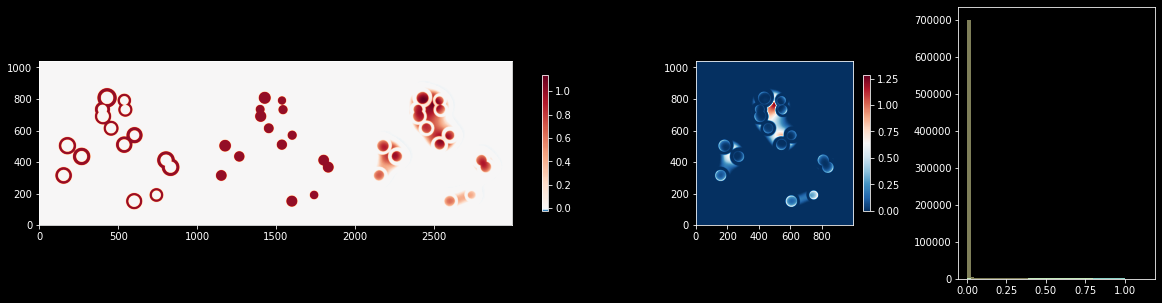

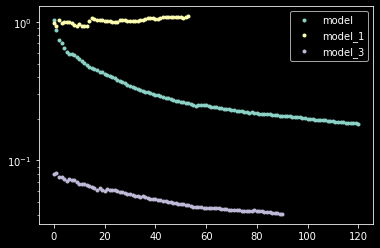

KeyboardInterrupt: ignored

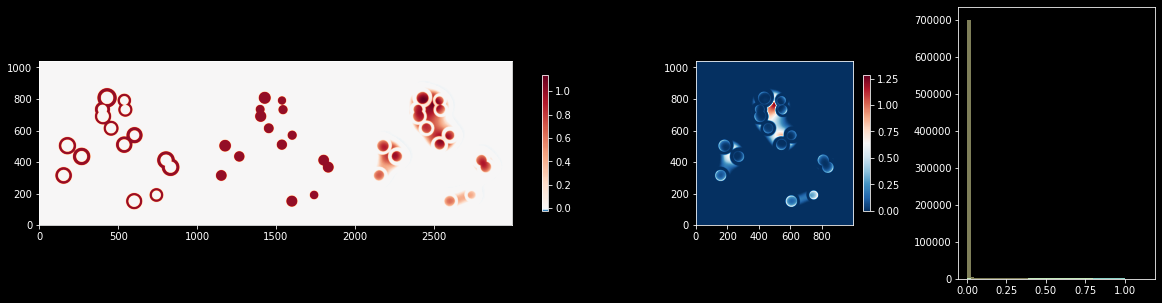

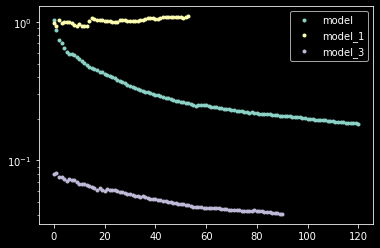

In [90]:
##@title TV Loop
# tf.debugging.set_log_device_placement(False)

i = 0;

vis = visualizer(batch_size=DATASET_BATCH_N, model_name=ca.name)
next(vis)

err_fig = plt.figure()
err_ax = err_fig.add_subplot(label="Loss")


for i in range(1000+1):

    batch = data_iter.get_next()
    source, target = split_data_to_x_y(batch)
    metrics = ca.train_step((source.repack()[0], target))

    ca_metrics.setdefault(ca.name, appenDict()).update(metrics)

    if i % 10 == 0:

        # Evaluate the model on (source, target) returning (loss, cell_loss, yhat)
        yhat = ca(source.repack()[0])
        cell_mse = tf.math.squared_difference(yhat, target)
        loss = ca_metrics[ca.name]["loss"][-1]

        clear_output(wait=True)

        err_ax.clear()
        for run_name, run_metrics in ca_metrics.items():
            err_ax.plot(run_metrics["loss"], '.', label=run_name, alpha=1)
        err_ax.set_yscale('log')
        err_ax.legend()

        batch["yhat"] = yhat
        batch["cell_mse"] = cell_mse
        display(vis.send(batch))
        display(err_fig)


In [79]:
x0 = data_iter.get_next()
source, target = split_data_to_x_y(x0)
x, _ = source.repack()
x_first = x[0:1]
print(x_first.shape)
center_slice = np.s_[:, target.shape[1]//2, target.shape[2]//2, :]
with tf.GradientTape() as g:
    g.watch(x_first)
    yhat = ca(x_first)
    yhat_central = yhat[center_slice]
    dyc_dx = g.gradient(yhat_central, x_first)

dyc_dx.shape


    


(1, 933, 1011, 3)


TensorShape([1, 933, 1011, 3])

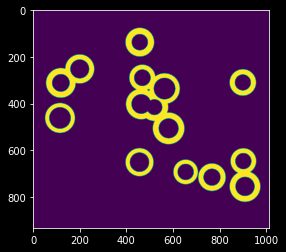

In [80]:
plt.imshow(x_first[0, ..., 0])

In [81]:
norm_dyc_dx = tf.reduce_sum(tf.math.abs(dyc_dx), axis=-1)[0]

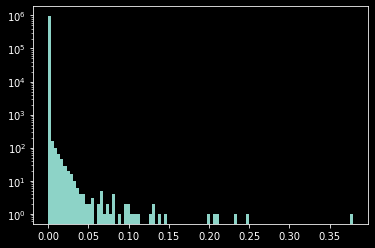

In [82]:
_ = plt.hist(tf.reshape(norm_dyc_dx, [-1]), bins=100, log=True)

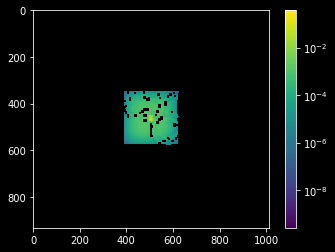

In [83]:
plt.imshow(norm_dyc_dx, norm=colors.LogNorm())
plt.colorbar()

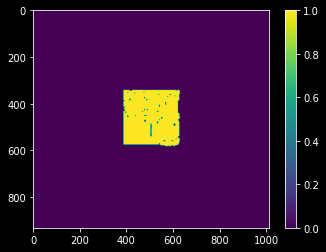

In [84]:
plt.imshow(norm_dyc_dx != 0)
plt.colorbar()